In [2]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import numpy as np
plt.style.use('seaborn')

In [81]:
eva = pd.read_csv('cache/eva.csv')
sales = pd.read_csv('cache/sales.csv')
pageViews = pd.read_csv('cache/pageViews.csv')
mg = pd.merge(eva, sales, on=['week', 'year'])
result = pd.merge(mg, pageViews, on=['week', 'year'])

In [82]:
train = result[5:130].copy()
test = result[130:-10].copy()
y_test_org = test.copy()
test['num'] = 0

In [111]:
train

week  year   hao  zhong  cha        hf      avgH      avgZ      avgC  \
5       6  2017    80     19    9  1.000000  0.740741  0.175926  0.083333   
6       7  2017   105     31   14  0.966667  0.700000  0.206667  0.093333   
7       8  2017   157     43   17  0.755760  0.723502  0.198157  0.078341   
8       9  2017   193     42   18  0.881423  0.762846  0.166008  0.071146   
9      10  2017   206     36   10  0.968254  0.817460  0.142857  0.039683   
..    ...   ...   ...    ...  ...       ...       ...       ...       ...   
125    24  2019   900    196   72  0.934075  0.770548  0.167808  0.061644   
126    25  2019  1393    313  128  0.944384  0.759542  0.170665  0.069793   
127    26  2019   930    251  122  0.970069  0.713738  0.192632  0.093630   
128    27  2019   830    197   76  0.941976  0.752493  0.178604  0.068903   
129    28  2019   743    195   88  0.982456  0.724172  0.190058  0.085770   

         rateH  ...  avgPrice   price   num    hd           pv           uv  \
5    74.074074  ...      1.46  177.54   579  0.18  2148.115385  1122.423077   
6    70.000000  ...      2.12  176.88   958  0.21  3002.258065  1452.225806   
7    72.350230  ...      2.81  176.19   839  0.58  3319.172414  1596.275862   
8    76.284585  ...      1.73  177.27   895  0.31  3348.774194  1689.580645   
9    81.746032  ...      6.16  172.84  1363  0.78  5504.354839  2732.548387   
..         ...  ...       ...     ...   ...   ...          ...          ...   
125  77.054795  ...     41.06  137.94  4536  0.92  1557.464286   618.928571   
126  75.954198  ...     44.22  134.78  6883  0.97  2548.821429   895.000000   
127  71.373753  ...     13.48  165.52  1215  0.65  1166.607143   462.464286   
128  75.249320  ...     27.65  151.35  2895  0.92  2011.638889   851.472222   
129  72.417154  ...     21.96  157.04  3364  0.84  1752.048780   690.853659   

            cv         jsv       avgt      sv  
5    17.115385   59.368421  14.665000  2303.0  
6    23.548387   80.291667  17.069412  4969.0  
7    23.551724   86.181818  16.702667  3517.0  
8    24.548387   91.416667  15.547059  3958.0  
9    37.903226  122.166667  15.218824  4789.0  
..         ...         ...        ...     ...  
125   4.785714   47.964286  19.615714   439.0  
126   5.750000   80.821429  23.361429   524.0  
127   3.892857   33.464286  18.861429   917.0  
128   6.166667   55.888889  20.297333   718.0  
129   4.731707   56.414634  22.910714   750.0  

[125 rows x 22 columns]

In [103]:
cols = ['hao','zhong','cha','hf','avgH','avgZ','avgC','rateH','rateZ','rateC','price','hd',
        'pv','uv','cv','jsv','avgt','sv']

In [104]:
model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=160, silent=False, objective='reg:squarederror')
model.fit(train[cols], train['num'].values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=160,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=False, subsample=1, verbosity=1)

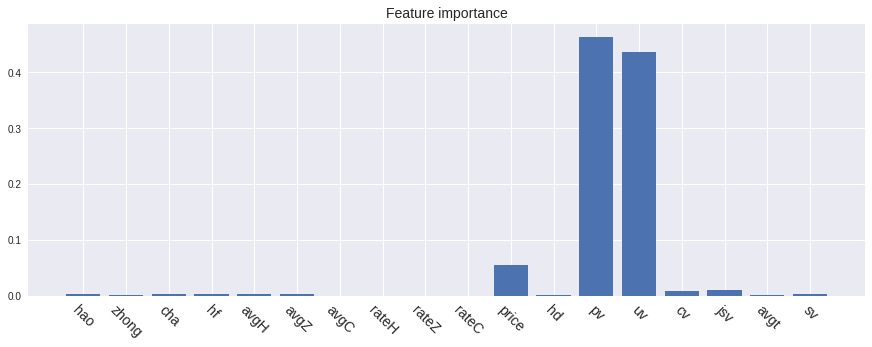

In [105]:
plt.figure(figsize=(15, 5))
plt.bar(range(len(cols)), model.feature_importances_)
plt.xticks(range(len(cols)), cols, rotation=-45, fontsize=14)
plt.title('Feature importance', fontsize=14)
plt.show()

In [67]:
ans = model.predict(test[cols])
test['num'] = ans

In [68]:
print('MAPE:', sum(abs((test['num'] - y_test_org['num']) / y_test_org['num'])) / y_test_org['num'].size * 100)

MAPE: 39.811605242603285


<Figure size 576x396 with 0 Axes>

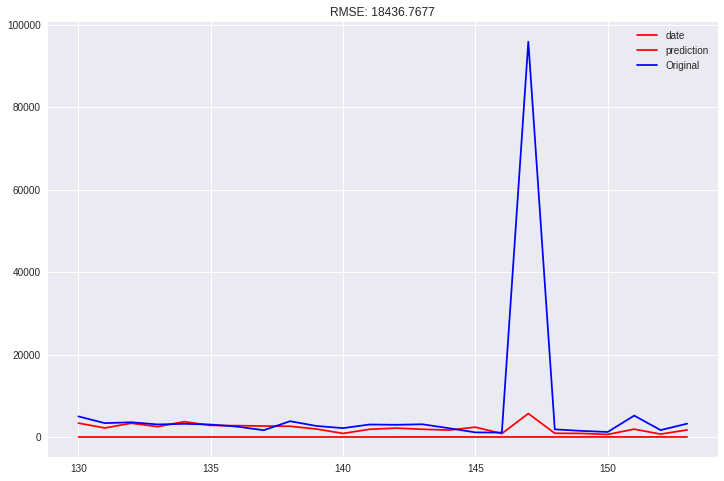

In [69]:
test_true_data = pd.DataFrame(data={'date': y_test_org['week'], 'actual': y_test_org['num'].values})
test_pred_data = pd.DataFrame(data={'date': test['week'], 'prediction': test['num'].values})
plt.figure()
test_pred_data.plot(color='red', label='Predict', figsize=(12, 8))
test_true_data.actual.plot(color='blue', label='Original', figsize=(12, 8))
plt.title('RMSE: %.4f' % np.sqrt(sum((test['num'] - y_test_org['num']) ** 2) / y_test_org['num'].size))
plt.legend(loc='best')  # 将样例显示出来
plt.grid(True)
plt.show()

In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[cols])
y_base = explainer.expected_value
train['pred'] = model.predict(train[cols])
print(y_base)
# '销量平均值'
print(train['pred'].mean())

2380.9653
2380.9658203125


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [71]:
j = 10
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[j], train[cols].iloc[j])

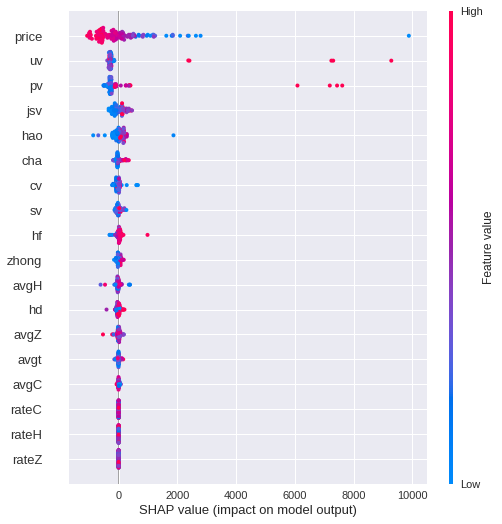

In [72]:
shap.summary_plot(shap_values, train[cols])

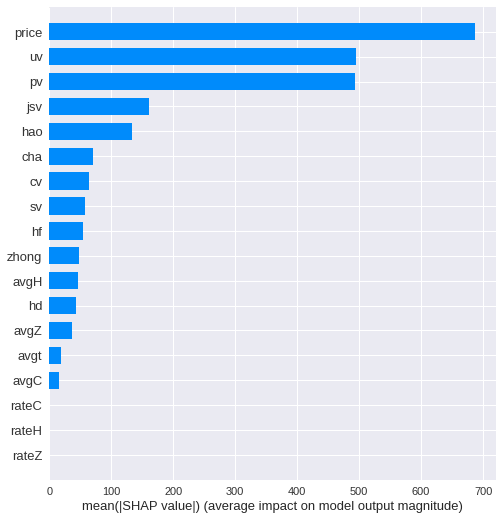

In [73]:
shap.summary_plot(shap_values, train[cols], plot_type="bar")

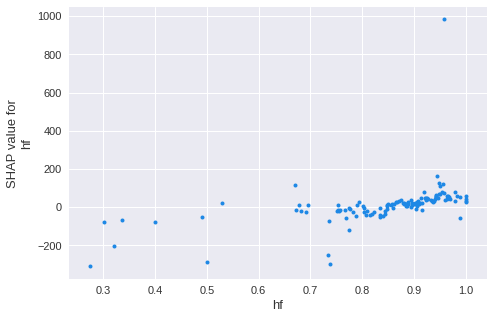

In [74]:
shap.dependence_plot('hf', shap_values, train[cols], interaction_index=None, show=False)

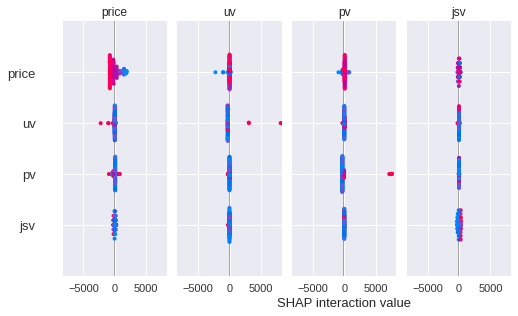

In [75]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(train[cols])
shap.summary_plot(shap_interaction_values, train[cols], max_display=4)

In [76]:
shap.dependence_plot('hao', shap_values, train[cols], interaction_index='international_reputation', show=False)

Could not find feature named: international_reputation
